In [25]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymc as pm
import arviz as az
import xarray as xr
from sklearn.preprocessing import StandardScaler
import statsmodels.graphics.tsaplots as smg
import pytensor
import pytensor.tensor as pt
from pymc.pytensorf import collect_default_updates

az.style.use("arviz-darkgrid")

settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5, 
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)

In [26]:
# Using links as reference
# - https://www.pymc.io/projects/examples/en/latest/time_series/AR.html
# - https://www.pymc.io/projects/examples/en/latest/time_series/Forecasting_with_structural_timeseries.html

$$
y_t = \rho_0 + \rho_1 y_{t-1} + \rho_2 y_{t-2} + \epsilon_t 
$$


#### Interating backwards k times we get: 
$
\\
y_t = \rho y_{t-1} + \epsilon_t \\
y_{t-1} = \rho y_{t-2} + \epsilon_{t-1} \\
y_{t-2} = \rho y_{t-3} + \epsilon_{t-2} \\
y_{t-k} = \rho y_{t-(k-1)} + \epsilon_{t-k}  \\
\vdots \\
y_t = \rho^k y_{t-k} + \sum_{j=0}^{k-1} \rho^j \epsilon_{t-j}
$

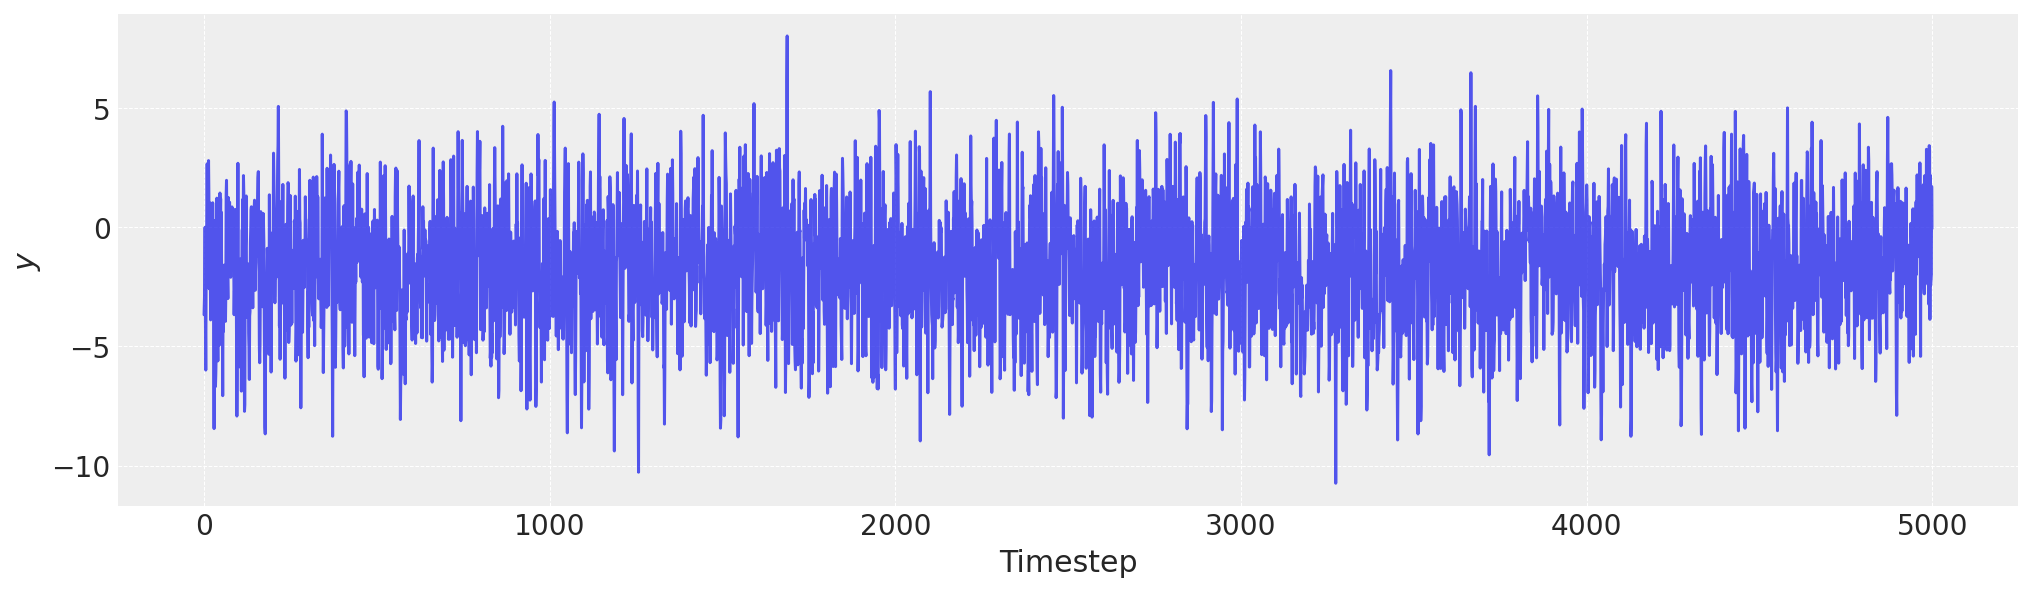

In [27]:
T = 10000

# true stationarity:
true_rho = 0.7, -0.3
# true standard deviation of the innovation:
true_sigma = 2.0
# true process mean:
true_center = -1.0

y = np.random.normal(loc=true_center, scale=true_sigma, size=T)
y[1] += true_rho[0] * y[0]
for t in range(2, T - 100):
    y[t] += true_rho[0] * y[t - 1] + true_rho[1] * y[t - 2]

##### This is important, burn the first 5000 samples
y = y[-5000:]
plt.plot(y, alpha=0.8)
plt.xlabel("Timestep")
plt.ylabel("$y$");

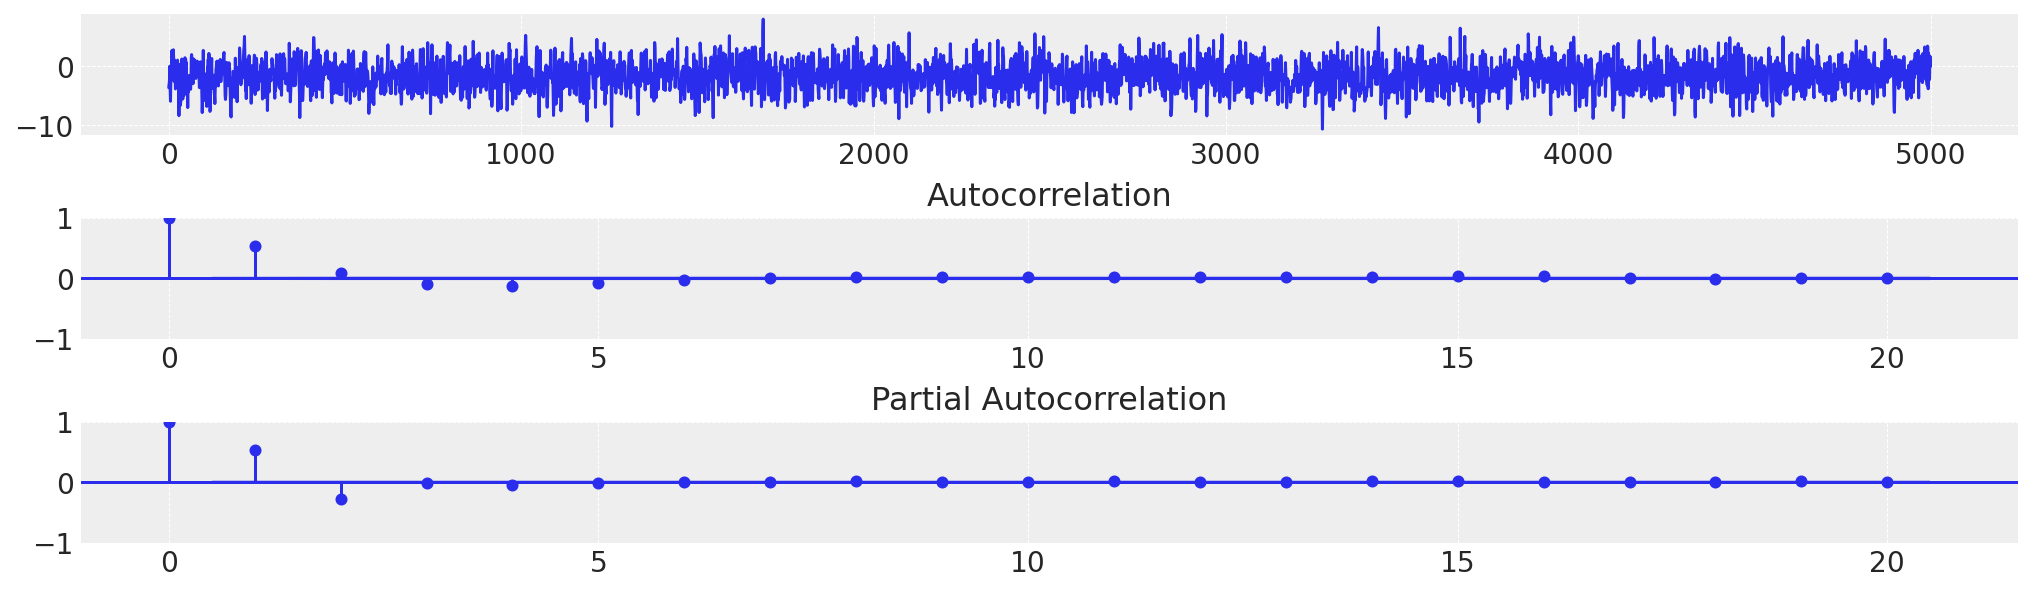

In [28]:
_, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(y)
smg.plot_acf(y, lags=20, ax=ax2);
smg.plot_pacf(y, lags=20, ax=ax3);

In [29]:
with pm.Model() as ar1:
    # assumes 95% of prob mass is between -2 and 2
    rho = pm.Normal("rho", mu=0.0, sigma=1.0, shape=2)
    # precision of the innovation term
    tau = pm.Exponential("tau", lam=0.5)

    likelihood = pm.AR(
        "y", rho=rho, tau=tau, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, tau]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 10 seconds.


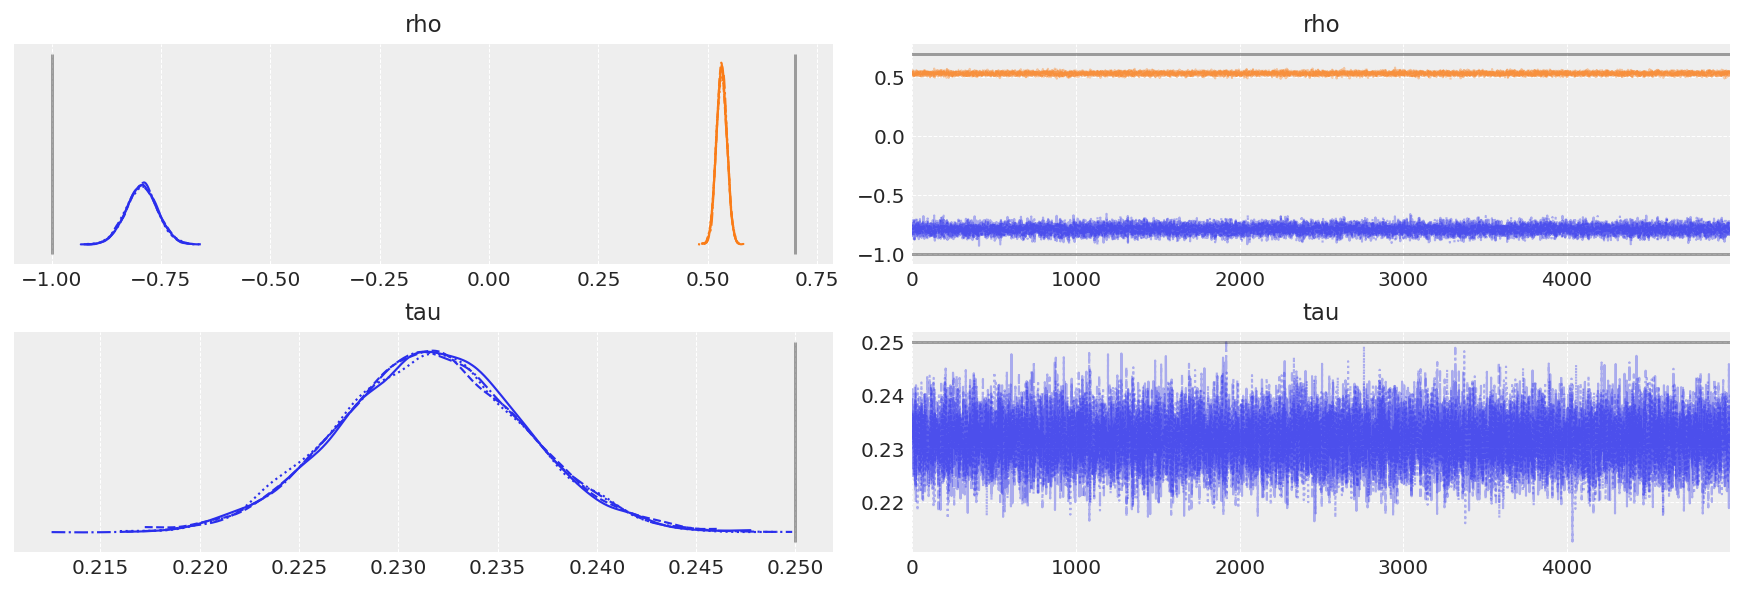

In [30]:
az.plot_trace(
    idata,
    lines=[
        ("rho", {}, [true_center, true_rho[0]]),
        ("tau", {}, true_sigma**-2),
    ],
);

In [31]:
with pm.Model() as ar2:
    rho = pm.Normal("rho", 0.0, 1.0, shape=3)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR(
        "y", rho=rho, sigma=sigma, constant=True, init_dist=pm.Normal.dist(0, 10), observed=y
    )

    idata = pm.sample(
        1000,
        tune=2000
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 6 seconds.


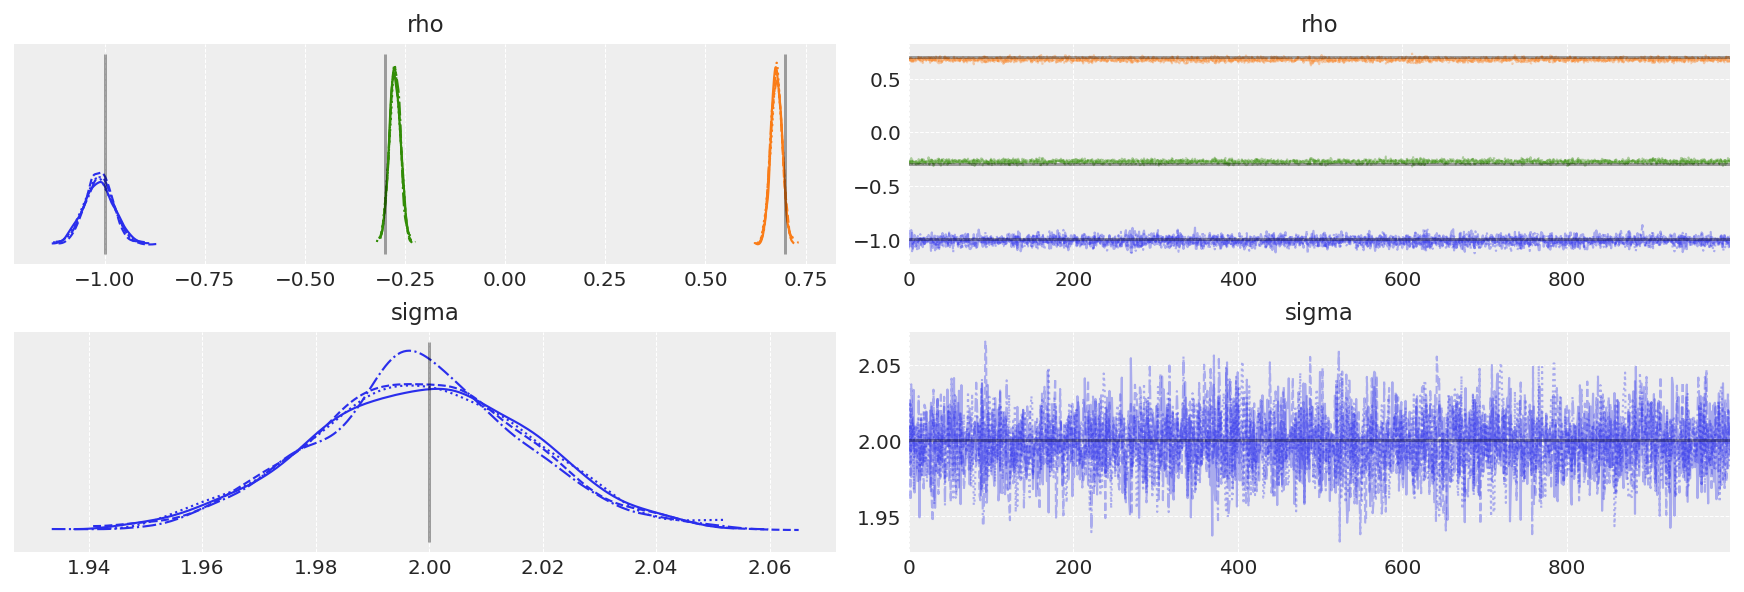

In [32]:
az.plot_trace(
    idata,
    lines=[
        ("rho", {}, (true_center,) + true_rho),
        ("sigma", {}, true_sigma),
    ],
);

######################################################################################

## Defining AR2 model in PyMC with Scan

In [33]:
# https://gist.github.com/ricardoV94/a49b2cc1cf0f32a5f6dc31d6856ccb63#file-pymc_timeseries_ma-ipynb

seed = sum(map(ord, "PyMC+AR(2)"))
rng = np.random.default_rng(seed)

In [34]:
lags = 2
trials = 100

def ar_dist(ar_init, rho, sigma, size):
    
    def ar_step(x_tm2, x_tm1, rho, sigma):
        mu = x_tm1 * rho[0] + x_tm2 * rho[1]
        x = mu + pm.Normal.dist(sigma=sigma)
        return x, collect_default_updates([x])
    
    ar_innov, _ = pytensor.scan(
        fn=ar_step,
        outputs_info=[{"initial": ar_init, "taps":range(-lags, 0)}],
        non_sequences=[rho, sigma],
        n_steps=trials-lags,
        strict=True,
    )
    
    return ar_innov

coords = {
    "lags": range(-lags, 0),
    "steps": range(trials - lags),
    "trials": range(trials),
}
with pm.Model(coords=coords, check_bounds=False) as m:
    
    rho = pm.Normal("rho", mu=0, sigma=0.2, dims=("lags",))
    sigma = pm.HalfNormal("sigma", sigma=.2)
    
    ar_init_obs = pm.MutableData("ar_init_obs", np.zeros(lags), dims=("lags",))
    ar_init = pm.Normal("ar_init", observed=ar_init_obs, dims=("lags",))

    ar_innov_obs = pm.MutableData("ar_innov_obs", np.zeros(trials-lags), dims=("steps",))
    ar_innov = pm.CustomDist(
        "ar_dist",
        ar_init,
        rho, 
        sigma,
        dist=ar_dist,
        observed=ar_innov_obs,
        dims=("steps",)
    )
        
    ar = pm.Deterministic("ar", pt.concatenate([ar_init, ar_innov], axis=-1), dims=("trials",))

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


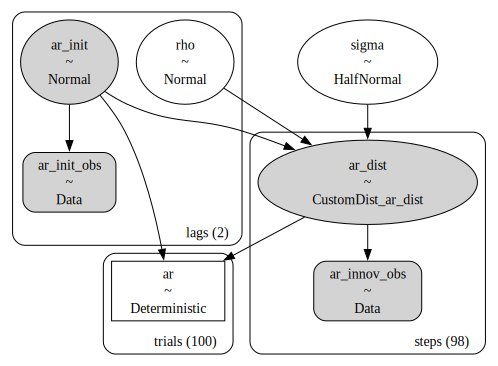

In [35]:
pm.model_to_graphviz(m)

In [36]:
with m:
    prior = pm.sample_prior_predictive(
        samples=100,
        random_seed=rng,
    )

Sampling: [ar_dist, ar_init, rho, sigma]


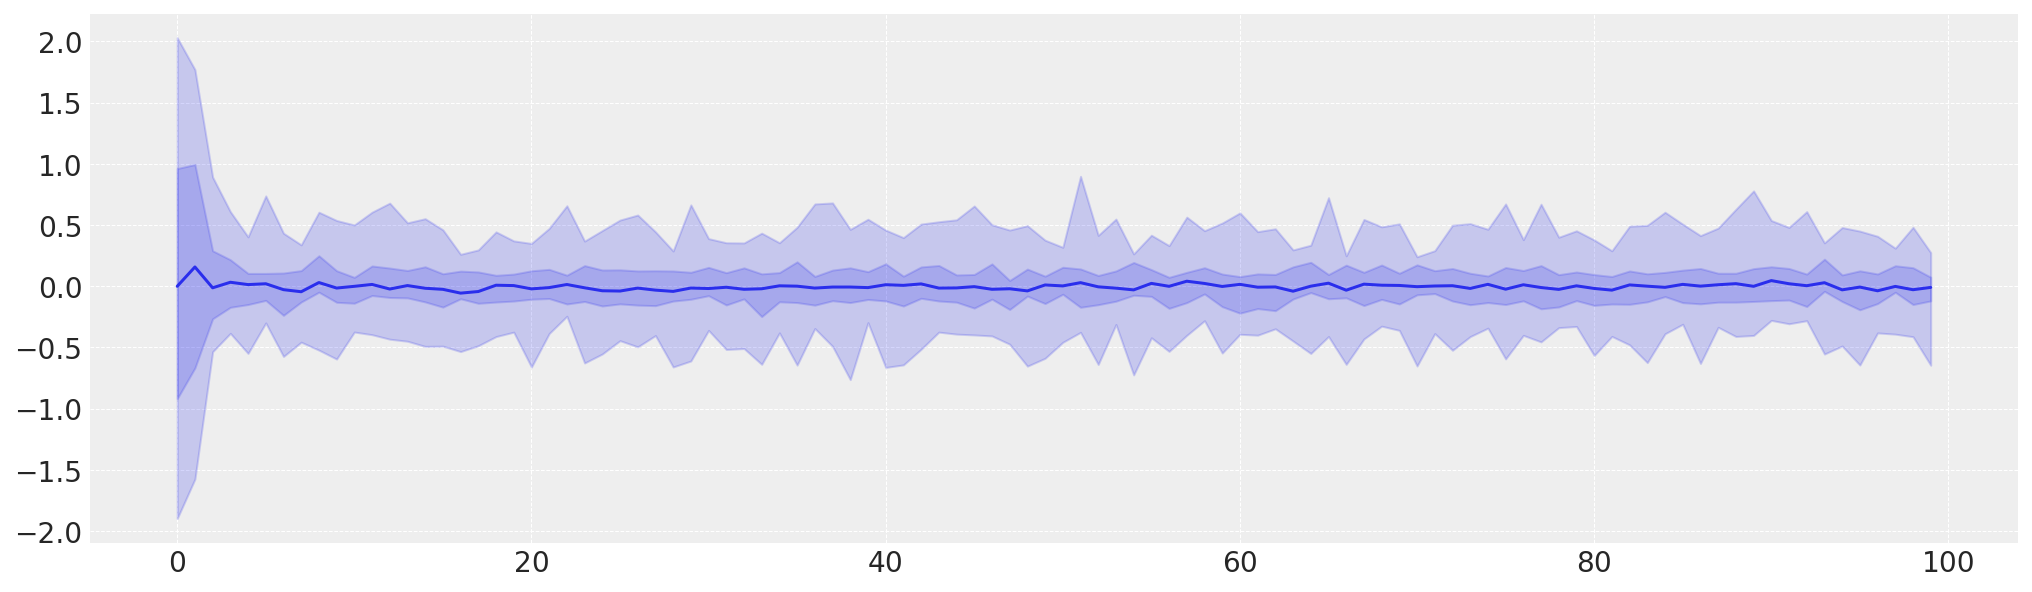

In [37]:
for hdi_prob in (0.94, 0.64):
    hdi = az.hdi(prior.prior["ar"], hdi_prob=hdi_prob)["ar"]
    lower=hdi.sel(hdi="lower")
    upper=hdi.sel(hdi="higher")
    plt.fill_between(np.arange(trials), y1=lower, y2=upper, alpha=.2, color="C0")
plt.plot(prior.prior["ar"].mean(("chain", "draw")), color="C0");

# Prior predictive

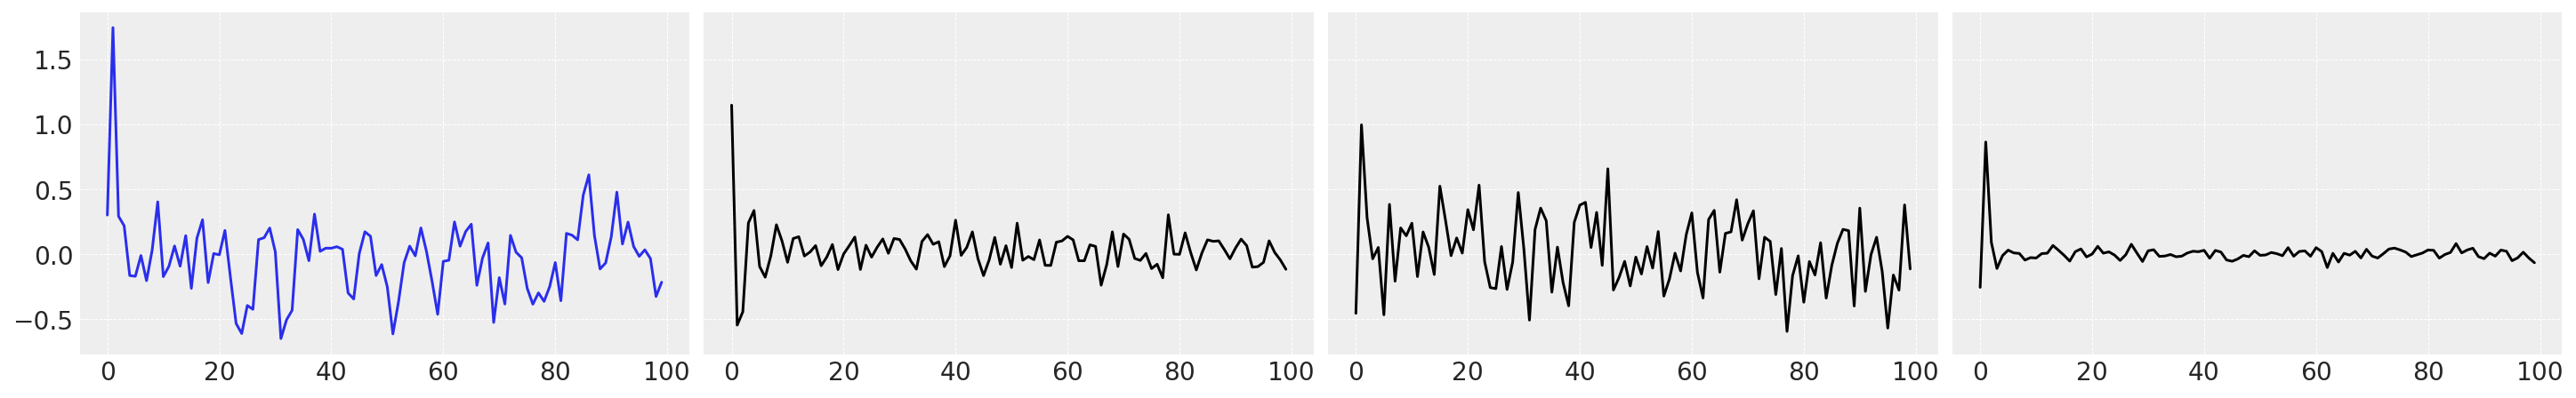

In [38]:
_, ax = plt.subplots(1, 4, figsize=(20, 3), sharey=True)
chosen_draw = 1
for i, axi in enumerate(ax, start=chosen_draw):
    axi.plot(prior.prior["ar"].isel(draw=i, chain=0), color="C0" if i == chosen_draw else "k")

# Posterior Predictive

In [39]:

prior_draw = prior.prior.isel(chain=0, draw=chosen_draw)

ar_init_obs.set_value(prior_draw["ar"].values[:lags])
ar_innov_obs.set_value(prior_draw["ar"].values[lags:])
ar_obs = prior_draw["ar"].values
rho_true = prior_draw["rho"].values
sigma_true = prior_draw["sigma"].values

print(f"rho_true={np.round(rho_true, 3)}, {sigma_true=:.3f}")

rho_true=[0.259 0.135], sigma_true=0.236


In [40]:
with m:
    trace = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


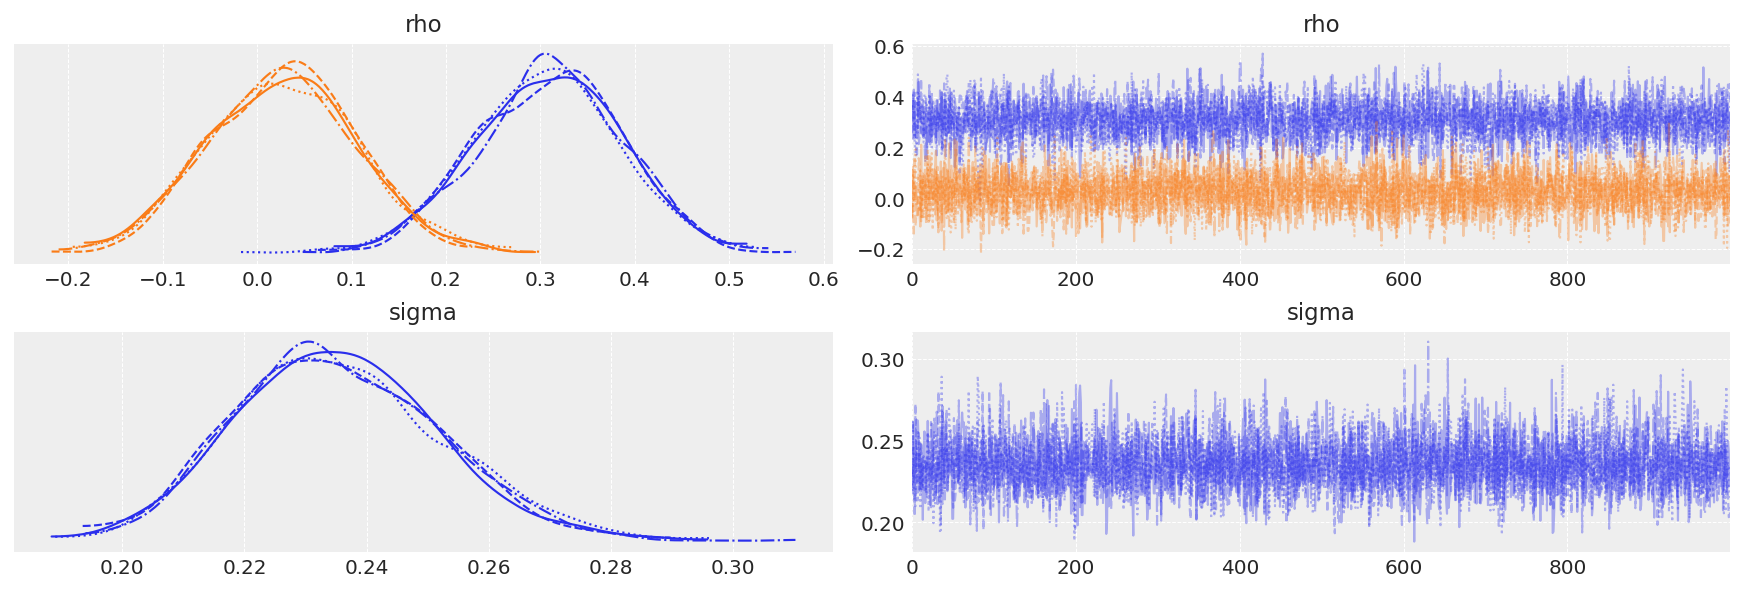

In [41]:
az.plot_trace(trace, var_names=["rho", "sigma"]);

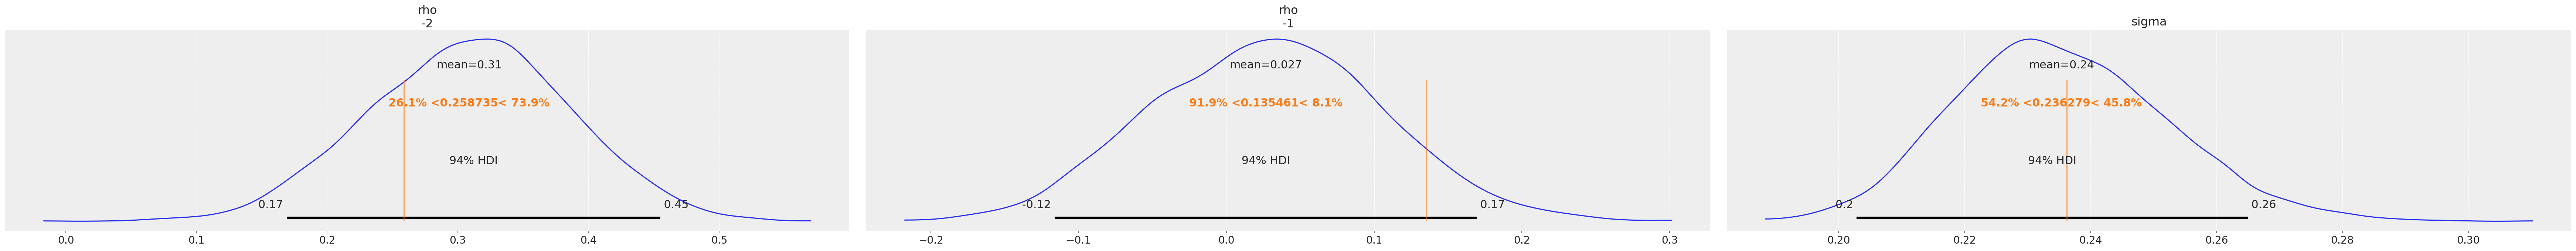

In [42]:
az.plot_posterior(trace, var_names=["rho", "sigma"], ref_val=[*rho_true, sigma_true]);

In [43]:
with m:
    post_pred = pm.sample_posterior_predictive(
        trace, 
        random_seed=rng, 
    )

Sampling: [ar_dist, ar_init]


Output()

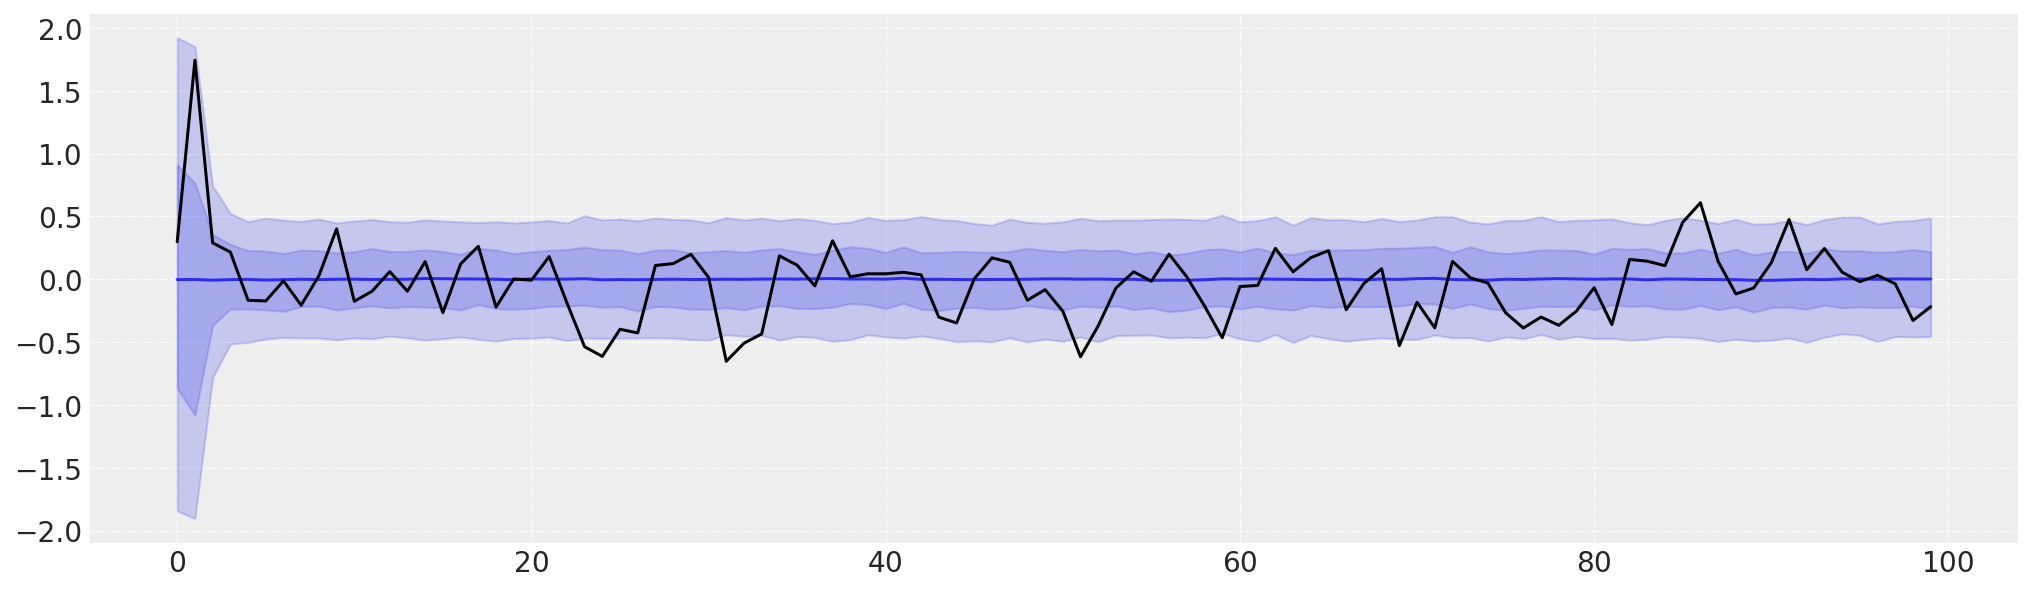

In [44]:
post_pred_ar = post_pred.posterior_predictive["ar"]
for hdi_prob in (0.94, 0.64):
    hdi = az.hdi(post_pred_ar, hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    plt.fill_between(np.arange(trials), y1=lower, y2=upper, alpha=.2, color="C0")
plt.plot(post_pred_ar.mean(("chain", "draw")), color="C0")    
plt.plot(ar_obs, color="k");

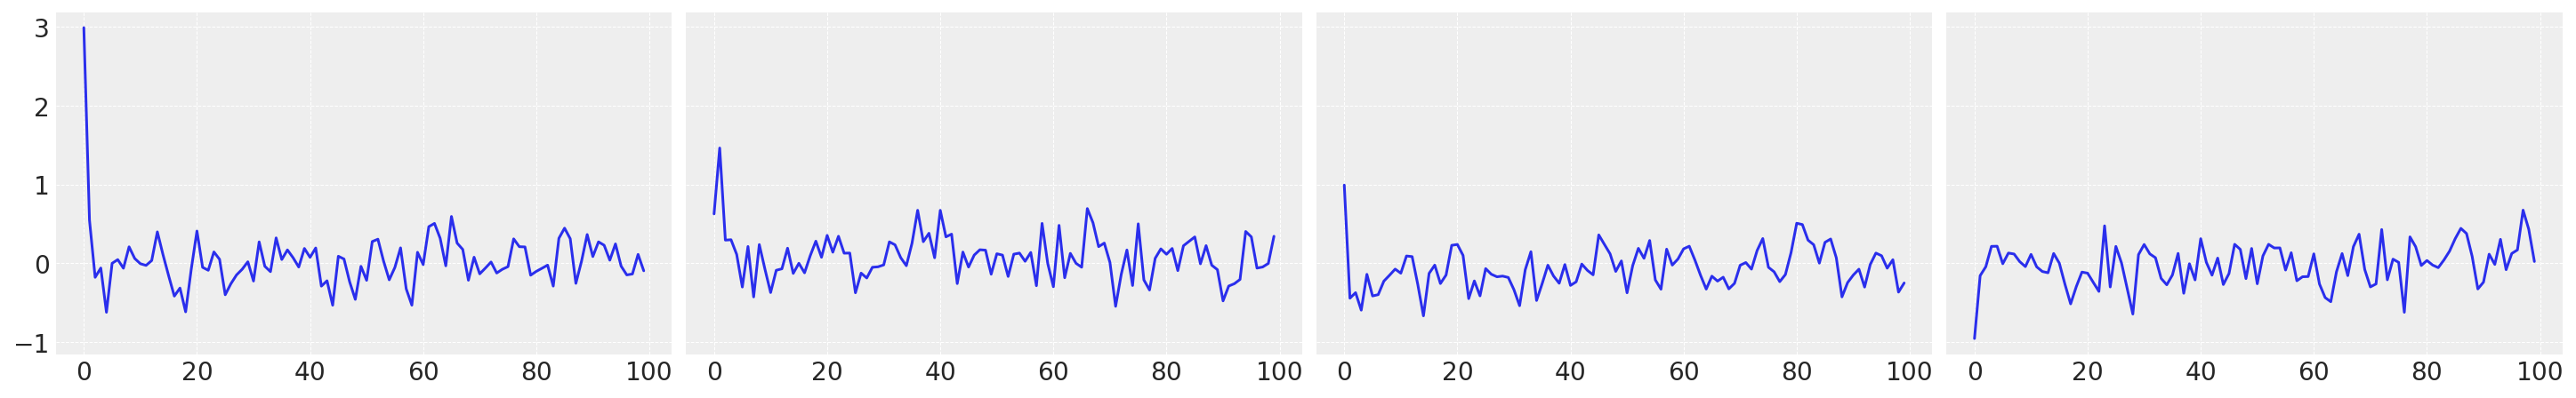

In [45]:
_, ax = plt.subplots(1, 4, figsize=(20, 3), sharey=True)
for i, axi in enumerate(ax):
    axi.plot(post_pred.posterior_predictive["ar"].isel(draw=i, chain=0), color="C0")